In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '../')
import astropy.units as u
from shocksgo import generate_stellar_fluxes, generate_solar_fluxes

In [2]:
from astropy.table import Table

table = Table.read('/Users/bmmorris/git/libra/libra/data/spt_mamajek.txt', format="ascii")

In [3]:
solar_type = table[(table['Teff'] < 6400) & (4000 < table['Teff'])]

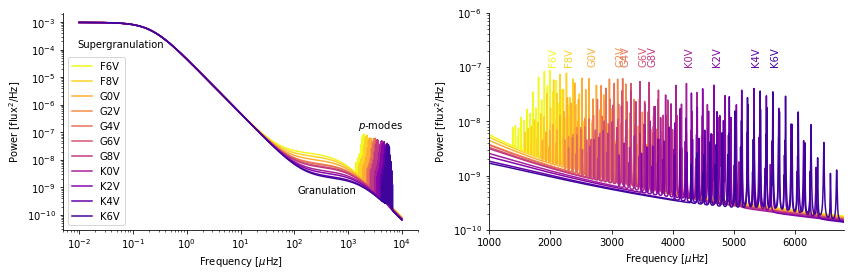

In [4]:
from astropy.constants import M_sun, R_sun, L_sun
from scipy.ndimage import gaussian_filter1d

freqs = np.logspace(-2, 4, 50000) # uHz

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for i in range(0, len(solar_type), 2):
    t, f, kernel = generate_stellar_fluxes(duration=60*u.min, M=solar_type['Msun'][i] * M_sun, 
                                           R=solar_type['R_Rsun'][i] * R_sun,
                                           L=10**solar_type['logL'][i] * L_sun, 
                                           T_eff=solar_type['Teff'][i] * u.K)
    color = plt.cm.plasma_r(i/len(solar_type))
    psd = kernel.get_psd(2*np.pi*freqs * 1e-6)/(2*np.pi)
    ax[0].loglog(freqs, psd, color=color, label=solar_type['SpT'][i])
    ax[0].legend(loc='lower left')
    ax[1].semilogy(freqs, psd, color=color)
    
    condition = (freqs < 7000) & (freqs > 1500)
    nu_max_ind = np.argmax(gaussian_filter1d(psd[condition], 100))
    nu_max = freqs[condition][nu_max_ind]
    power_max = psd[condition][nu_max_ind]

    ax[1].annotate(solar_type['SpT'][i], xy=(nu_max, 1e-7), rotation=90, 
                   color=color, va='bottom')
    ax[1].set(xlim=[1000, 6800], ylim=[1e-10, 1e-6])
    
ax[0].annotate('Supergranulation', xy=(6e-2, 1e-4), va='bottom', ha='center')
ax[0].annotate('Granulation', xy=(4e2, 5e-10), va='bottom', ha='center')
ax[0].annotate('$p$-modes', xy=(4e3, 1e-7), va='bottom', ha='center')

for axis in ax: 
    axis.set_xlabel('Frequency [$\mu$Hz]')
    axis.set_ylabel('Power [flux$^2$/Hz]')
    for s in 'right top'.split(): 
        axis.spines[s].set_visible(False)
        
fig.savefig("paper_plots/appendix1.pdf", bbox_inches='tight')